# AI for Injection Moulding

## Importing Modules

In [5]:
# For data exploration
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# For Machine Learning
from sklearn.model_selection import train_test_split

## Reading Feature Engineered Data

### Input Data
- The feature engineered have a matrix with shape (22, 1542) $\equiv$ (features, number of datapoints)
- The features have the following meaning:
- Columsn 0 - 21 (total of 22 values)
    - last_point_in_time
    - peak_value
    - peak_time
    - peak_width
    - peak_prominence
    - peak2_value
    - peak2_time
    - peak2_width
    - peak2_prominence
    - mean
    - median
    - min
    - max
    - std
    - 75%quantile
    - 90%quantile
    - root-mean-square
    - skew  (extent of asymmetry)
    - kurtosis  (degree of peakness)
    - change_time (time of most abrupt change in series)
    - value just before middle
    - value just after middle

In [6]:
# loading feature engineered data in a dataframe
# we rename the column names to not have issues when joining the dataframes

full_data_df = pd.DataFrame()
ramp_df = pd.read_csv("./Data/ram_features.csv", header=None)

injectionp_df = pd.read_csv("./Data/injection_pressure_features.csv", header=None)
injectionp_df.columns = np.arange(22, 44, dtype=int)

sensorp_df = pd.read_csv("./Data/sensor_pressure_features.csv", header=None)
sensorp_df.columns = np.arange(44, 66, dtype=int)

labels_df = pd.read_csv("./Data/Y2.csv", header=None)

full_data_df = ramp_df.join(injectionp_df.join(sensorp_df))
full_data_df[66] = labels_df
full_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,20.000099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029574,...,1.348450e+07,12153000.0,36289200.0,1.810414e+07,1.183458,-0.425242,0.656510,19348500.0,0.759095,1
1,20.000099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029305,...,1.183386e+07,12232000.0,32058500.0,1.635327e+07,1.100449,-0.568736,0.174720,17200000.0,0.755031,1
2,20.000099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029168,...,1.173513e+07,12930000.0,32070000.0,1.640097e+07,1.093430,-0.552906,0.734860,17237500.0,0.760460,1
3,20.000099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029315,...,1.247266e+07,11968000.0,33437000.0,1.695804e+07,1.113614,-0.569749,0.177975,17847000.0,0.762628,1
4,20.000099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029339,...,1.298727e+07,12652000.0,35078200.0,1.765239e+07,1.147779,-0.482242,0.670877,18733500.0,0.729493,1


- We normalize the data before proceeding to use boxplot for every feature

In [7]:
cols_to_norm = [i for i in range(0, 66)]  # we exclude the labels
full_data_df[cols_to_norm] = full_data_df[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())
full_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,-0.999676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.501974,...,1.045017,-0.726272,1.080923,0.919813,1.672058,1.169527,-0.372553,1.087917,0.239571,1
1,-0.999676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.518824,...,-0.800240,-0.584643,-0.892881,-0.827658,-0.972617,-0.902328,-0.576610,-0.931479,0.126121,1
2,-0.999676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.548079,...,-0.910617,0.666707,-0.887516,-0.780052,-1.196270,-0.673753,-0.339368,-0.896233,0.277676,1
3,-0.999676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.443703,...,-0.086129,-1.057934,-0.249751,-0.224066,-0.553176,-0.916950,-0.575232,-0.323358,0.338197,1
4,-0.999676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.269275,...,0.489163,0.168318,0.515940,0.468939,0.535320,0.346533,-0.366468,0.509872,-0.586794,1


- **Note**: The NaN values are generated from columns which statistically have no relevance. The standard deviation of those numbers are zero (floating point) and its division by it during normalization produce those values.
- Now we will proceed to drop those features which do not contribute.

In [8]:
# we will not yet drop inplace=Tru the NaN before we will do boxplot it
full_data_df.dropna(axis=1).describe()  # we drop along the columns axis=1

,0,9,10,11,12,13,14,15,16,17,...,57,58,59,60,61,62,63,64,65,66
count,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,...,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1542.000000
mean,-9.996757e-01,1.948233e-14,6.801304e-15,1.680742e-15,-9.996757e-01,4.390205e-15,-4.510241e-14,-7.431669e-14,-2.044078e-14,1.594344e-15,...,-2.820053e-15,-1.198062e-16,-1.251053e-15,1.760229e-15,-1.271789e-15,4.607930e-16,-5.068722e-17,-1.211885e-15,3.317709e-15,0.700389
std,2.221166e-16,1.000000e+00,1.000000e+00,1.000000e+00,2.221166e-16,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.458236
min,-9.996757e-01,-2.718529e+00,-2.980763e+00,-3.562554e+00,-9.996757e-01,-3.392491e+00,-2.791275e+00,-2.713996e+00,-2.562774e+00,-3.802716e+00,...,-2.749356e+00,-3.568701e+00,-2.512066e+00,-2.730771e+00,-2.577519e+00,-1.293336e+00,-5.860820e-01,-2.519926e+00,-1.165349e+00,0.000000
25%,-9.996757e-01,-7.024125e-01,-7.518754e-01,-6.368523e-01,-9.996757e-01,-6.701804e-01,-5.668019e-01,-8.112096e-01,-8.058754e-01,-5.712700e-01,...,-7.248681e-01,-6.126554e-01,-7.202132e-01,-7.116764e-01,-7.111062e-01,-7.808198e-01,-5.733073e-01,-7.136551e-01,-5.320928e-01,0.000000
50%,-9.996757e-01,-7.296535e-02,2.327431e-02,-1.440073e-02,-9.996757e-01,2.249234e-03,-1.009711e-01,-9.383351e-02,1.239774e-02,1.194674e-01,...,1.341570e-02,2.758586e-02,2.299008e-02,1.116590e-02,-2.630358e-01,-3.717274e-01,-3.643709e-01,2.464398e-02,-1.152257e-01,1.000000
75%,-9.996757e-01,6.561977e-01,4.365399e-01,6.573717e-01,-9.996757e-01,6.552018e-01,6.226369e-01,6.425953e-01,5.297110e-01,6.938897e-01,...,7.145871e-01,6.814970e-01,6.994893e-01,7.253287e-01,5.821131e-01,4.717218e-01,-3.411480e-01,6.970319e-01,1.821477e-01,1.000000
max,-9.996757e-01,3.443609e+00,3.764368e+00,3.516085e+00,-9.996757e-01,3.549042e+00,3.578569e+00,3.457427e+00,3.815630e+00,3.356335e+00,...,2.571423e+00,3.389021e+00,2.421489e+00,2.402760e+00,6.999047e+00,9.178524e+00,2.684985e+00,2.378413e+00,4.206606e+00,1.000000


### Analysis of the ramp position dataframe with engineered features

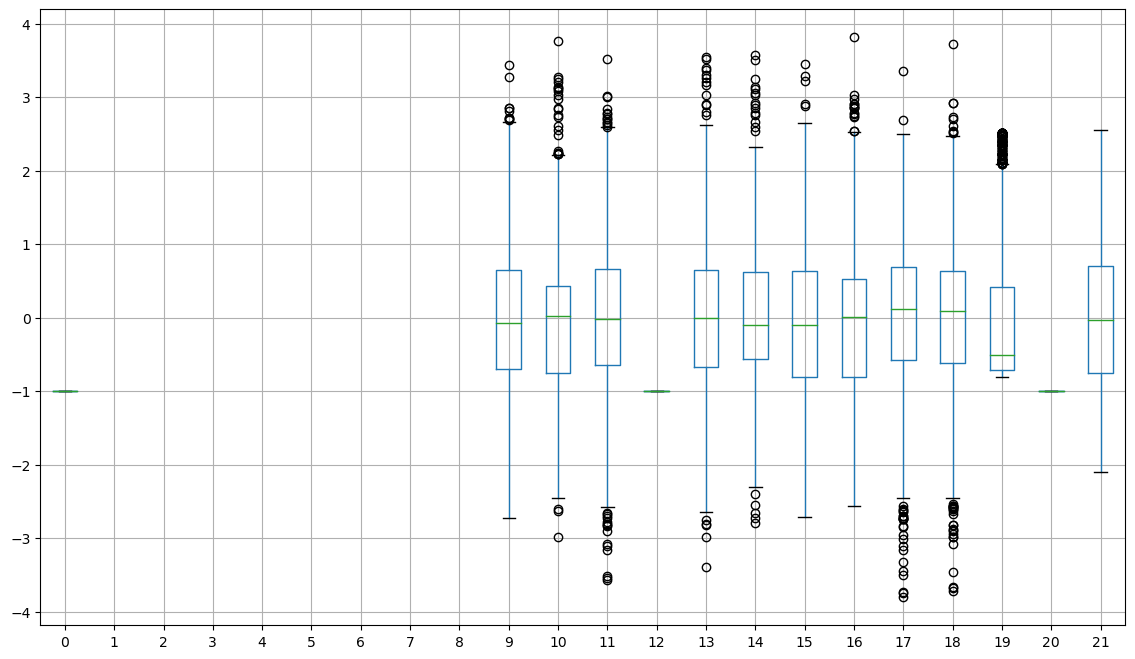

In [9]:
columns_given_0 = [i for i in range(22)]
full_data_df.boxplot(column=columns_given_0, figsize=(14, 8))
plt.show()

### Analysis of the injection pressure dataframe with engineered features

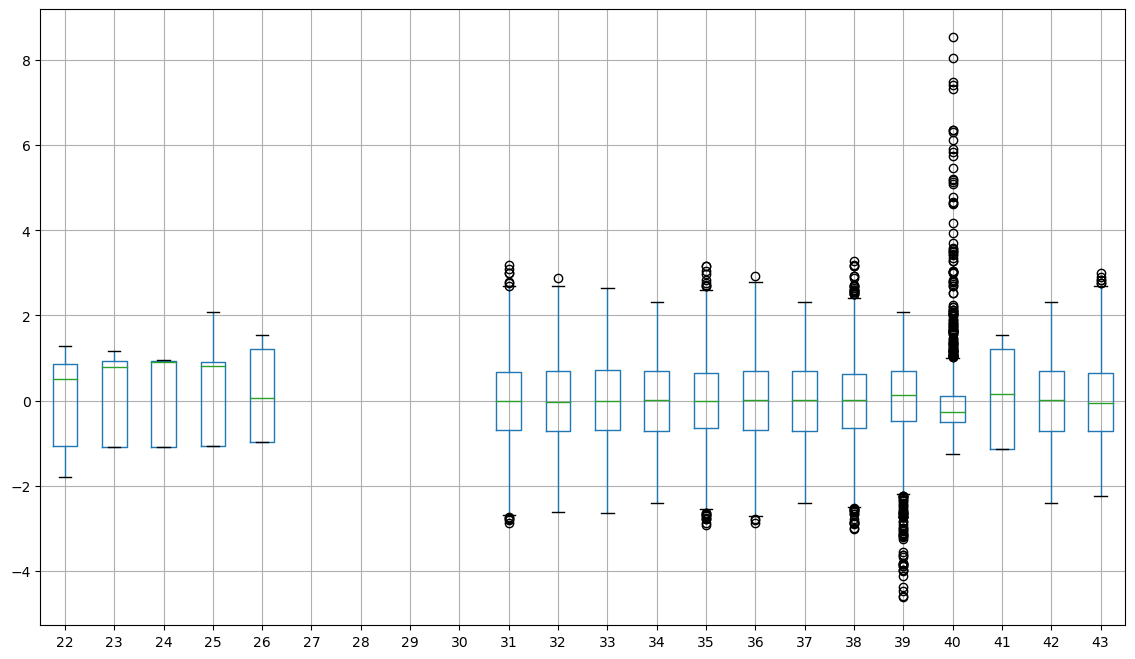

In [10]:
columns_given_1 = [i for i in range(22, 44)]
full_data_df.boxplot(column=columns_given_1, figsize=(14, 8))
plt.show()

### Analysis of the sensor pressure dataframe with engineered features

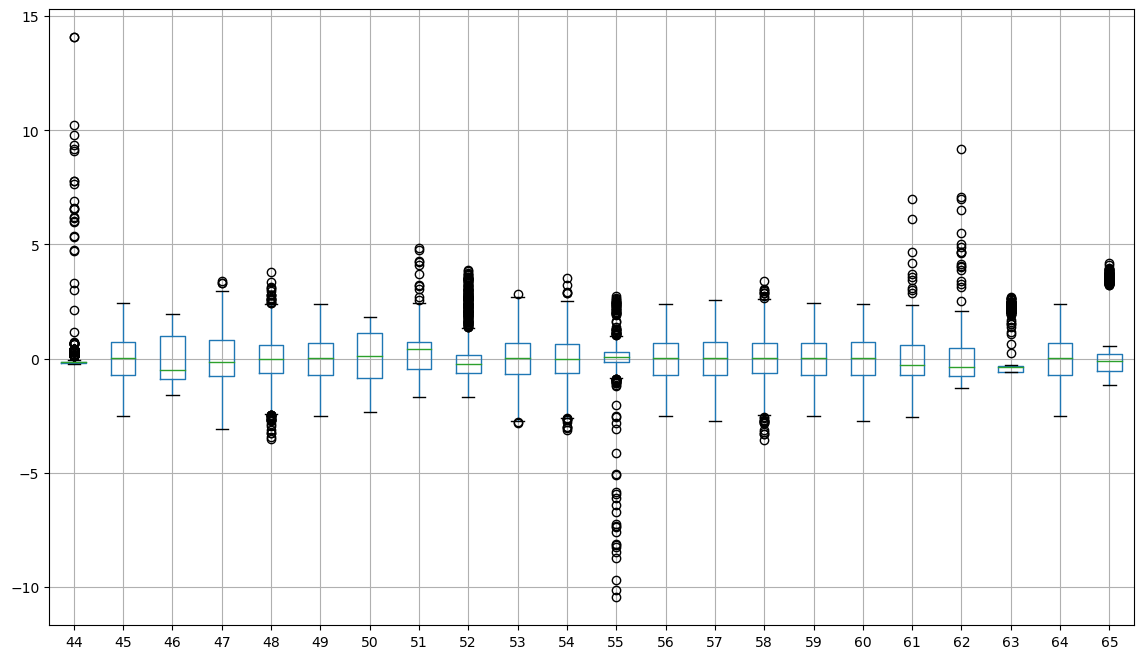

In [11]:
columns_given_2 = [i for i in range(44, 66)]
full_data_df.boxplot(column=columns_given_2, figsize=(14, 8))
plt.show()

In [12]:
# Checking datatypes
full_data_df.dtypes

0     float64
1     float64
2     float64
3     float64
4     float64
       ...   
62    float64
63    float64
64    float64
65    float64
66      int64
Length: 67, dtype: object

In [13]:
# Statistical description
full_data_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
count,1.542000e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.542000e+03,...,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1542.000000
mean,-9.996757e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.948233e-14,...,-2.820053e-15,-1.198062e-16,-1.251053e-15,1.760229e-15,-1.271789e-15,4.607930e-16,-5.068722e-17,-1.211885e-15,3.317709e-15,0.700389
std,2.221166e-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.458236
min,-9.996757e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.718529e+00,...,-2.749356e+00,-3.568701e+00,-2.512066e+00,-2.730771e+00,-2.577519e+00,-1.293336e+00,-5.860820e-01,-2.519926e+00,-1.165349e+00,0.000000
25%,-9.996757e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.024125e-01,...,-7.248681e-01,-6.126554e-01,-7.202132e-01,-7.116764e-01,-7.111062e-01,-7.808198e-01,-5.733073e-01,-7.136551e-01,-5.320928e-01,0.000000
50%,-9.996757e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.296535e-02,...,1.341570e-02,2.758586e-02,2.299008e-02,1.116590e-02,-2.630358e-01,-3.717274e-01,-3.643709e-01,2.464398e-02,-1.152257e-01,1.000000
75%,-9.996757e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.561977e-01,...,7.145871e-01,6.814970e-01,6.994893e-01,7.253287e-01,5.821131e-01,4.717218e-01,-3.411480e-01,6.970319e-01,1.821477e-01,1.000000
max,-9.996757e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.443609e+00,...,2.571423e+00,3.389021e+00,2.421489e+00,2.402760e+00,6.999047e+00,9.178524e+00,2.684985e+00,2.378413e+00,4.206606e+00,1.000000


#### Prunning Data

In [14]:
full_data_df.dropna(axis=1, inplace=True)
full_data_df.head()

,0,9,10,11,12,13,14,15,16,17,...,57,58,59,60,61,62,63,64,65,66
0,-0.999676,1.501974,1.939444,-0.343346,-0.999676,0.564167,1.715246,1.649904,1.958295,-1.773758,...,1.045017,-0.726272,1.080923,0.919813,1.672058,1.169527,-0.372553,1.087917,0.239571,1
1,-0.999676,-0.518824,-0.486110,0.360816,-0.999676,-0.387596,-0.449908,-0.656303,-0.797283,0.815002,...,-0.800240,-0.584643,-0.892881,-0.827658,-0.972617,-0.902328,-0.576610,-0.931479,0.126121,1
2,-0.999676,-1.548079,-2.029322,-0.295393,-0.999676,-0.073770,-1.500208,-1.993306,-1.710538,1.163351,...,-0.910617,0.666707,-0.887516,-0.780052,-1.196270,-0.673753,-0.339368,-0.896233,0.277676,1
3,-0.999676,-0.443703,-0.014819,-0.403499,-0.999676,0.731069,-0.191695,0.538220,-0.031719,-0.341763,...,-0.086129,-1.057934,-0.249751,-0.224066,-0.553176,-0.916950,-0.575232,-0.323358,0.338197,1
4,-0.999676,-0.269275,0.172989,-0.852749,-0.999676,0.531535,0.056051,-0.141051,0.033288,-0.487708,...,0.489163,0.168318,0.515940,0.468939,0.535320,0.346533,-0.366468,0.509872,-0.586794,1


- The length of the dataset after prunning is:

In [15]:
print(f"The number of datapoints is {len(full_data_df)}")
# we subtract the label from the number of attributes/features
print(f"The number of attributes/features is {len(full_data_df.columns) - 1}")

The number of datapoints is 1542
The number of attributes/features is 54


## Selecting the Machine Learning Model
-  Because were dealing with a classification problem but not a regression, we need to consider models that allows to classify.
- Let's start with:
    1. Decision trees & Ensembles
    2. kNN
    3. SVM
    4. Neural Networks

### Decision Trees & Ensembles
- We will start by using random forest

- Splitting the data

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    full_data_df.drop([66], axis=1),
    full_data_df[66],
    test_size=0.2)

- The new sizes:

In [32]:
X_train

,0,9,10,11,12,13,14,15,16,17,...,56,57,58,59,60,61,62,63,64,65
1267,-0.999676,0.577298,0.041878,0.316227,-0.999676,-0.467453,0.207838,-0.273592,0.333695,-0.051216,...,-1.082805,-1.381461,-0.396403,-1.247594,-1.231471,0.258625,1.205647,-0.396928,-1.082805,-0.483310
486,-0.999676,-1.068587,-0.911335,-0.338719,-0.999676,0.393552,-0.861654,-0.440924,-0.909330,0.375966,...,-0.106708,-0.191316,0.701666,-0.220359,-0.092364,-0.792471,-0.554700,2.081914,-0.106708,-0.309310
430,-0.999676,1.483910,2.221156,-0.260058,-0.999676,0.617871,1.305245,2.363966,1.971571,-1.735404,...,0.431390,0.498950,-1.239899,0.494479,0.332852,1.551685,1.126330,-0.591571,0.431390,0.021855
668,-0.999676,-0.767718,-1.074338,0.028505,-0.999676,0.025965,-0.491780,-0.573465,-0.811710,0.567347,...,0.465697,0.364808,1.317480,0.408028,0.562865,-0.897153,-0.871250,2.091679,0.465697,0.346851
690,-0.999676,-0.467624,0.041878,-0.563344,-0.999676,0.711888,-0.165524,0.505084,-0.069155,-0.311716,...,0.869388,1.086920,-0.627670,0.951691,0.965271,0.052620,-0.573018,-0.368235,0.869388,-0.100751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,-0.999676,0.782468,0.105662,0.724675,-0.999676,-0.860065,0.413711,-0.000227,0.315867,0.252520,...,-0.014597,-0.055463,0.141426,-0.037847,-0.039774,0.242937,0.224877,-0.386611,-0.014597,-0.964802
949,-0.999676,-1.263463,0.146412,-1.900159,-0.999676,1.896825,0.713797,0.024625,-0.193335,-0.982482,...,2.119468,2.175818,0.878253,2.114130,2.191483,-0.010679,-0.731168,-0.366766,2.119468,0.426551
900,-0.999676,-0.036026,-0.486110,1.114614,-0.999676,-1.052452,-0.561568,-0.868368,-0.683400,1.156899,...,-1.139199,-1.059956,-0.494557,-1.135996,-1.036010,-1.195705,-0.970855,2.183938,-1.139199,-0.432475
770,-0.999676,1.123710,1.292748,0.199288,-0.999676,-0.014896,0.956308,0.874541,1.198033,-0.836050,...,-1.034399,-1.038164,-1.465788,-1.040822,-1.169015,0.964567,1.197886,-0.301638,-1.034399,0.205625


In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
def eval_on_features(features, target, regressor):
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(40,20), dpi=40)
    x_ticks = np.arange(0, len(processed_data), len(processed_data) / 8)
    plt.xticks(x_ticks)
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    # Before plotting we scale back the predicted values
    y_train_scaled_back = scaler.inverse_transform(y_train.reshape(-1,1))
    y_test_scaled_back = scaler.inverse_transform(y_test.reshape(-1,1))
    y_pred_scaled_back = scaler.inverse_transform(y_pred.reshape(-1,1))
    y_pred_train_scaled_back = scaler.inverse_transform(y_pred_train.reshape(-1,1))
    plt.plot(processed_data["Date"][0:n_train], y_train_scaled_back, label="train", linewidth=5)
    plt.plot(processed_data["Date"][n_train:n_train + len(y_test)], y_test_scaled_back, '-', label="test", linewidth=5)
    plt.plot(processed_data["Date"][0:n_train], y_pred_train_scaled_back, '--', label="prediction train", linewidth=5)
    plt.plot(processed_data["Date"][n_train:n_train + len(y_test)], y_pred_scaled_back, '--', label="prediction test", linewidth=5)
    plt.xlabel("Date", fontsize=40)
    plt.ylabel("Energy Consumption (kW-h)", fontsize=40)
    plt.title(f"Energy Consumption Single French Household Prediction", fontsize=40)
    plt.legend(loc=(0.75,0.75), fontsize=40)
    msep = "{:.2f}".format(mean_squared_error(y_test, y_pred) * 100)
    r_score = "{:.2f}".format(regressor.score(X_test, y_test))
    pp = "{:.2f}".format((1 - mean_squared_error(y_test, y_pred)) * 100)
    result_str = "$\epsilon=$" + str(msep) + "%\n" + "R\u00b2=" + str(r_score) + "\n$\\alpha=$" + str(pp) + "%"
    plt.text("12/6/2008",1.9, result_str, fontsize=40, bbox={'facecolor': 'red', 'alpha' : 0.5, 'pad' : 10})
    print(f"The mean squared error is: {msep}%")
    print(f"Test-set R\u00b2: {r_score}")
    print(f"The precision is then: {pp}%")
    plt.show()